# Setup

In [1]:
%%bash
# Install deps from 
# https://github.com/mwydmuch/ViZDoom/blob/master/doc/Building.md#-linux

apt-get update


apt-get install build-essential zlib1g-dev libsdl2-dev libjpeg-dev \
nasm tar libbz2-dev libgtk2.0-dev cmake git libfluidsynth-dev libgme-dev \
libopenal-dev timidity libwildmidi-dev unzip

# Boost libraries
apt-get install libboost-all-dev


Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [83.3 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2,990 kB]
Get:13 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 Packages [3,422 kB]
Hit:

In [2]:
!pip install vizdoom --quiet 
!pip install ray  --quiet
!pip install ray['rllib'] --quiet
!pip install Ipython --upgrade --quiet

     |████████████████████████████████| 15.7 MB 2.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 59.4 MB 1.2 MB/s 
     |████████████████████████████████| 8.8 MB 61.7 MB/s 
     |████████████████████████████████| 4.1 MB 57.0 MB/s 
     |████████████████████████████████| 468 kB 72.1 MB/s 
     |████████████████████████████████| 125 kB 2.1 MB/s 
     |████████████████████████████████| 1.2 MB 12.9 MB/s 
     |████████████████████████████████| 626 kB 63.3 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 793 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 70.6 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency confli

In [3]:
import os 
from google.colab import drive
import sys


#need this to load vizdoom module 
system_path = '/content/drive/MyDrive/GitHub/INM363-Project'
drive.mount('/content/drive')
sys.path.append(system_path)

system_path = '/content/drive/MyDrive/GitHub/INM363-Project/src' 
sys.path.append(system_path)

#need this to use gpu on ray 
os.environ['PYTHONPATH'] = '/content/drive/MyDrive/GitHub/INM363-Project' 
os.environ['PYTHONPATH']

Mounted at /content/drive


'/content/drive/MyDrive/GitHub/INM363-Project'

In [4]:
from src.vizdoom_gym.envs.VizDoomEnv import VizdoomEnv
from src.vizdoom_gym.envs.VizDoomEnv_def import VizDoomVeryDenseReward

In [16]:
from ray.tune.registry import register_env
import gym
import os
import ray
import ray.rllib.agents.ppo as ppo
from ray.rllib.algorithms.callbacks import RE3UpdateCallbacks
import shutil
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from fnmatch import fnmatch 
import numpy as np

sns.set()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device: ", device, "\n")

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

device:  cuda:0 

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


# Initialize Ray

In [30]:

ray.shutdown()
print("Shutdown ray")
# start Ray -- add `local_mode=True` here for debugging
ray.init(ignore_reinit_error=True,  num_cpus =1, num_gpus = 1) #local_mode=True,

print("Initialized ray")

# register the custom environment
select_env = "VizDoomVeryDenseReward-v0"

register_env(select_env, lambda config: VizDoomVeryDenseReward())

print("registered environment")

Shutdown ray


2022-09-26 17:13:38,864	INFO worker.py:1518 -- Started a local Ray instance.


Initialized ray
registered environment


# PPO

In [54]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["num_workers"] = 0
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = True 
config['in_evaluation'] = True

agent = ppo.PPOTrainer(config, env=select_env)

print("created agent")

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


2022-09-26 17:24:58,011	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [55]:
# examine the trained policy
#policy = agent.get_policy()
#model = policy.model

#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [56]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


ppo_chkpt_mean_rewards = np.array([]) 
ppo_chkpt_std_rewards = np.array([]) 
ppo_chkpt_mean_steps = np.array([]) 
ppo_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  ppo_chkpt_mean_rewards = np.append(ppo_chkpt_mean_rewards, np.mean(total_reward) )
  ppo_chkpt_std_rewards = np.append(ppo_chkpt_std_rewards, np.std(total_reward))
  ppo_chkpt_mean_steps = np.append(ppo_chkpt_mean_steps, np.mean(total_steps))
  ppo_chkpt_std_steps = np.append(ppo_chkpt_std_steps, np.std(total_steps))



2022-09-26 17:25:07,048	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000001
2022-09-26 17:25:07,050	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 79.24559307098389, '_episodes_total': 23}


Total number of checkpoints:  11
checkpoint_000001


2022-09-26 17:25:07,868	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000010
2022-09-26 17:25:07,870	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 772.7665793895721, '_episodes_total': 228}


checkpoint_000010
(RolloutWorker pid=9739) config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
(RolloutWorker pid=9739) scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
(RolloutWorker pid=9739) episode timeout: 800
(RolloutWorker pid=9739) screen resolution: 320X240


(RolloutWorker pid=9739) 2022-09-26 17:25:08,241	WARNING env.py:143 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-09-26 17:25:08,606	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000020
2022-09-26 17:25:08,608	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1547.5107760429382, '_episodes_total': 450}


checkpoint_000020


2022-09-26 17:25:09,166	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000030
2022-09-26 17:25:09,169	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 2310.000259876251, '_episodes_total': 668}


checkpoint_000030


2022-09-26 17:25:09,719	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000040
2022-09-26 17:25:09,721	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 3089.934685230255, '_episodes_total': 900}


checkpoint_000040


2022-09-26 17:25:10,252	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000050
2022-09-26 17:25:10,254	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 3884.1780467033386, '_episodes_total': 1125}


checkpoint_000050


2022-09-26 17:25:10,798	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000060
2022-09-26 17:25:10,801	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 4680.400778532028, '_episodes_total': 1355}


checkpoint_000060


2022-09-26 17:25:11,335	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000070
2022-09-26 17:25:11,336	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 5445.642360210419, '_episodes_total': 1587}


checkpoint_000070


2022-09-26 17:25:11,890	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000080
2022-09-26 17:25:11,894	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 6215.729983091354, '_episodes_total': 1817}


checkpoint_000080


2022-09-26 17:25:12,467	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000090
2022-09-26 17:25:12,468	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 6986.986060380936, '_episodes_total': 2032}


checkpoint_000090


2022-09-26 17:25:13,287	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/ppo/easy_dense/checkpoint_000100
2022-09-26 17:25:13,291	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 7757.01603603363, '_episodes_total': 2262}


checkpoint_000100


In [58]:
results_pth = chkpt_root + '/' + 'result.csv'
ppo_df = pd.read_csv(results_pth) 
ppo_df['eps_cumsum'] = ppo_df['episodes_this_iter'].cumsum()
ppo_df = ppo_df[['checkpoint', 'eps_cumsum']]
ppo_df.checkpoint = ppo_df['checkpoint'].astype(int)
ppo_df.head()

ppo_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = ppo_df[~(ppo_df['eps_cumsum'].where(ppo_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  ppo_cum_eps.append(eps_num)

In [59]:
print(f"Total episodes: {ppo_cum_eps}")
print(f"Mean reward: {ppo_chkpt_mean_rewards}")
print(f"Std reward: {ppo_chkpt_std_rewards}")
print(f"Mean steps: {ppo_chkpt_mean_steps}")
print(f"Std steps: {ppo_chkpt_std_steps}")

#check length of lists are the same 
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_rewards)
assert len(ppo_cum_eps) == len(ppo_chkpt_mean_steps)



Total episodes: [23.0, 228.0, 450.0, 668.0, 900.0, 1125.0, 1355.0, 1587.0, 1817.0, 2032.0, 2262.0]
Mean reward: [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Std reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean steps: [12. 12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Std steps: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## PPO avg reward

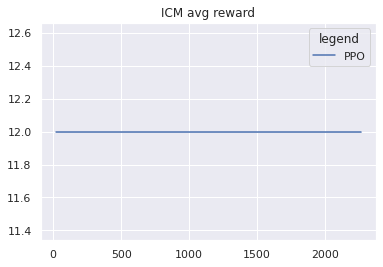

In [60]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(ppo_cum_eps, ppo_chkpt_mean_rewards, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards, ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards, color='b', alpha=0.2) 


plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()


## PPO avg steps

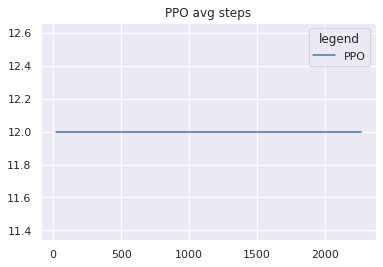

In [61]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(ppo_cum_eps, ppo_chkpt_mean_steps, 'b-', label='PPO')
plt.fill_between(ppo_cum_eps, (ppo_chkpt_mean_steps - ppo_chkpt_std_steps), (ppo_chkpt_mean_steps + ppo_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("PPO avg steps") 
plt.show()


# ICM 

In [62]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
#config["num_workers"] = 1
config["framework"] = "torch"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["preprocessor_pref"] = "rllib"
config['batch_mode'] = 'complete_episodes'

#changing this for evaluation time 
config['explore'] = True
config['in_evaluation'] = True

config["num_workers"] = 0 


config["exploration_config"] = {
    "type": "Curiosity",  # <- Use the Curiosity module for exploring.
    "eta": 0.01, #0.001,  # Weight for intrinsic rewards before being added to extrinsic ones.
    "lr": 0.001,  # Learning rate of the curiosity (ICM) module.
    "feature_dim": 288,  # Dimensionality of the generated feature vectors.
    # Setup of the feature net (used to encode observations into feature (latent) vectors).
    "feature_net_config": {
        "fcnet_hiddens": [],
        "fcnet_activation": "relu",
    },
    "inverse_net_hiddens": [256],  # Hidden layers of the "inverse" model.
    "inverse_net_activation": "relu",  # Activation of the "inverse" model.
    "forward_net_hiddens": [256],  # Hidden layers of the "forward" model.
    "forward_net_activation": "relu",  # Activation of the "forward" model.
    "beta": 0.2,  # Weight for the "forward" loss (beta) over the "inverse" loss (1.0 - beta).
    # Specify, which exploration sub-type to use (usually, the algo's "default"
    # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
   
    "sub_exploration": {
#        "type": "EpsilonGreedy",
#        "initial_epsilon": 1.0, #0.01,
#        "final_epsilon": 0.01, #0.001
        "type": "StochasticSampling",
        
    }
}
config["vf_clip_param"] = 400
agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


2022-09-26 17:25:32,582	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [63]:
#create environment 
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240
(scheduler +15m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


In [64]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))

#chkpt_mean_rewards = [] 
#chkpt_me

icm_chkpt_mean_rewards = np.array([]) 
icm_chkpt_std_rewards = np.array([]) 
icm_chkpt_mean_steps = np.array([]) 
icm_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  icm_chkpt_mean_rewards = np.append(icm_chkpt_mean_rewards, np.mean(total_reward) )
  icm_chkpt_std_rewards = np.append(icm_chkpt_std_rewards, np.std(total_reward))
  icm_chkpt_mean_steps = np.append(icm_chkpt_mean_steps, np.mean(total_steps))
  icm_chkpt_std_steps = np.append(icm_chkpt_std_steps, np.std(total_steps))



2022-09-26 17:25:33,904	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000001
2022-09-26 17:25:33,910	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 41.17420268058777, '_episodes_total': 48}


Total number of checkpoints:  10
checkpoint_000001


2022-09-26 17:25:34,498	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000010
2022-09-26 17:25:34,502	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 412.0427384376526, '_episodes_total': 464}


checkpoint_000010


2022-09-26 17:25:35,090	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000020
2022-09-26 17:25:35,093	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 825.0300531387329, '_episodes_total': 913}


checkpoint_000020


2022-09-26 17:25:35,680	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000030
2022-09-26 17:25:35,682	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1237.8470997810364, '_episodes_total': 1363}


checkpoint_000030


2022-09-26 17:25:36,260	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000040
2022-09-26 17:25:36,263	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 1647.7657797336578, '_episodes_total': 1825}


checkpoint_000040


2022-09-26 17:25:36,841	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000050
2022-09-26 17:25:36,843	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2057.087105989456, '_episodes_total': 2274}


checkpoint_000050


2022-09-26 17:25:37,417	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000060
2022-09-26 17:25:37,419	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 2467.050355195999, '_episodes_total': 2731}


checkpoint_000060


2022-09-26 17:25:37,998	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000070
2022-09-26 17:25:38,001	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 2877.723343372345, '_episodes_total': 3184}


checkpoint_000070


2022-09-26 17:25:38,590	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000080
2022-09-26 17:25:38,597	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 3288.296109199524, '_episodes_total': 3649}


checkpoint_000080


2022-09-26 17:25:39,184	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/icm/easy_dense_no_tpenalty/checkpoint_000090
2022-09-26 17:25:39,186	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 3698.9123249053955, '_episodes_total': 4100}


checkpoint_000090


In [65]:
results_pth = chkpt_root + '/' + 'result.csv'
icm_df = pd.read_csv(results_pth) 
icm_df['eps_cumsum'] = icm_df['episodes_this_iter'].cumsum()
icm_df = ppo_df[['checkpoint', 'eps_cumsum']]
icm_df.checkpoint = icm_df['checkpoint'].astype(int)
icm_df.head()

,checkpoint,eps_cumsum
0,1,23.0
1,2,45.0
2,3,69.0
3,4,89.0
4,5,113.0


In [66]:
icm_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = icm_df[~(icm_df['eps_cumsum'].where(icm_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  icm_cum_eps.append(eps_num)

print(f"Total episodes: {icm_cum_eps}")
print(f"Mean reward: {icm_chkpt_mean_rewards}")
print(f"Std reward: {icm_chkpt_std_rewards}")
print(f"Mean steps: {icm_chkpt_mean_steps}")
print(f"Std steps: {icm_chkpt_std_steps}")

#check length of lists are the same 
assert len(icm_cum_eps) == len(icm_chkpt_mean_rewards)
assert len(icm_cum_eps) == len(icm_chkpt_mean_steps)

Total episodes: [23.0, 228.0, 450.0, 668.0, 900.0, 1125.0, 1355.0, 1587.0, 1817.0, 2032.0]
Mean reward: [12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Std reward: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Mean steps: [12. 12. 12. 12. 12. 12. 12. 12. 12. 12.]
Std steps: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


## ICM avg reward

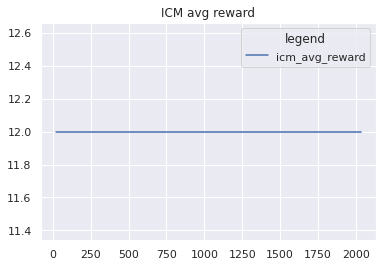

In [67]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'b-', label='icm_avg_reward')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg reward") 
plt.show()



## ICM avg steps

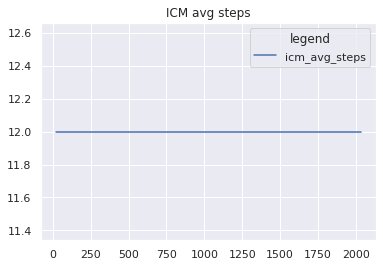

In [68]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'b-', label='icm_avg_steps')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("ICM avg steps") 
plt.show()



# RE3

In [28]:
class RE3Callbacks(RE3UpdateCallbacks, config["callbacks"]):
  pass

In [42]:
# configure the environment and create agent
config = ppo.DEFAULT_CONFIG.copy()
config["log_level"] = "WARN"
config["model"] = {"dim": 42, 
                   "grayscale": True,
                   }
config["num_gpus"] = 1
config["num_workers"] = 0 #check why this is set to 0!  
config["preprocessor_pref"] = "rllib"
config['explore'] = True 
config['in_evaluation'] = True
config["framework"] = "tf"
config["seed"] = 12345
config["callbacks"] = RE3Callbacks
config["exploration_config"] = {
    "type": "RE3",
     "embeds_dim": 128,
     "rho": 0.1, # Beta decay factor, used for on-policy algorithm.
     "k_nn": 7, # Number of neighbours to set for K-NN entropy estimation.
     "encoder_net_config": {
         "fcnet_hiddens": [],
         "fcnet_activation": "relu",
     },
     # `reward = r + beta * intrinsic_reward`
     "beta": 0.2,
     # Schedule to use for beta decay, one of constant" or "linear_decay".
     "beta_schedule": 'constant',
     # Specify, which exploration sub-type to use (usually, the algo's "default"
     # exploration, e.g. EpsilonGreedy for DQN, StochasticSampling for PG/SAC).
     "sub_exploration": {
         "type": "StochasticSampling",
     }
}
agent = ppo.PPOTrainer(config, env=select_env)
print("created agent")

/usr/local/lib/python3.7/dist-packages/ray/_private/ray_option_utils.py:273: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  stacklevel=1,


config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


/usr/local/lib/python3.7/dist-packages/gym/core.py:173: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed) instead.
  "Function `env.seed(seed)` is marked as deprecated and will be removed in the future. "
2022-09-26 17:19:14,144	WARNING util.py:65 -- Install gputil for GPU system monitoring.


created agent


In [43]:
env = gym.make('VizDoomVeryDenseReward-v0')

config file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/very_dense_reward.cfg
scenario file: /content/drive/MyDrive/GitHub/INM363-Project/scenarios/custom/test/easy_dense_reward_fixed_start.wad
episode timeout: 800
screen resolution: 320X240


In [44]:

chkpt_root = "/content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense" 

pattern = '*checkpoint*'
checkpoints = [x for x in os.listdir(chkpt_root) if fnmatch(x,pattern )]


print("Total number of checkpoints: ", len(checkpoints))


re3_chkpt_mean_rewards = np.array([]) 
re3_chkpt_std_rewards = np.array([]) 
re3_chkpt_mean_steps = np.array([]) 
re3_chkpt_std_steps = np.array([]) 


for chkpt_dir in checkpoints:
  chkpt_pth = chkpt_root + '/' + chkpt_dir 
  print(chkpt_dir)
  agent.restore(chkpt_pth)

  num_episodes = 10
  total_reward = []
  total_steps = [] 
  #chkpt_mean_reward = 0 

  for i in range(num_episodes):
    state = env.reset()
    eps_reward = 0
    eps_steps = 0 
    n_step = 200

    for step in range(n_step):
          action = agent.compute_action(state)
          state, reward, done, info = env.step(action)
          eps_reward += reward

          #if episode ends early
          if done == 1:
              total_reward.append(eps_reward)
              total_steps.append(step+1)
              state = env.reset()
              break

    #if episode timeout
    if done == 0:
      total_reward.append(eps_reward)
      total_steps.append(n_step)

  #get mean and std over all episodes
  re3_chkpt_mean_rewards = np.append(re3_chkpt_mean_rewards, np.mean(total_reward) )
  re3_chkpt_std_rewards = np.append(re3_chkpt_std_rewards, np.std(total_reward))
  re3_chkpt_mean_steps = np.append(re3_chkpt_mean_steps, np.mean(total_steps))
  re3_chkpt_std_steps = np.append(re3_chkpt_std_steps, np.std(total_steps))



2022-09-26 17:19:18,967	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000001
2022-09-26 17:19:18,969	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 64.96083569526672, '_episodes_total': 42}


Total number of checkpoints:  11
checkpoint_000001


2022-09-26 17:19:26,634	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000010
2022-09-26 17:19:26,636	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 10, '_timesteps_total': None, '_time_total': 581.8988029956818, '_episodes_total': 452}


checkpoint_000010


2022-09-26 17:19:31,866	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000020
2022-09-26 17:19:31,870	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 20, '_timesteps_total': None, '_time_total': 1157.5595436096191, '_episodes_total': 913}


checkpoint_000020


2022-09-26 17:19:37,462	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000030
2022-09-26 17:19:37,463	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 30, '_timesteps_total': None, '_time_total': 1730.6989047527313, '_episodes_total': 1394}


checkpoint_000030
(scheduler +9m31s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


2022-09-26 17:19:43,644	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000040
2022-09-26 17:19:43,648	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 40, '_timesteps_total': None, '_time_total': 2313.8183403015137, '_episodes_total': 1859}


checkpoint_000040


2022-09-26 17:19:47,961	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000050
2022-09-26 17:19:47,966	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 50, '_timesteps_total': None, '_time_total': 2887.5175592899323, '_episodes_total': 2327}


checkpoint_000050


2022-09-26 17:19:50,587	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000060
2022-09-26 17:19:50,589	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 60, '_timesteps_total': None, '_time_total': 3463.4613485336304, '_episodes_total': 2814}


checkpoint_000060


2022-09-26 17:19:54,758	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000070
2022-09-26 17:19:54,761	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 70, '_timesteps_total': None, '_time_total': 4040.0543451309204, '_episodes_total': 3322}


checkpoint_000070


2022-09-26 17:19:56,985	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000080
2022-09-26 17:19:56,986	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 80, '_timesteps_total': None, '_time_total': 4613.855907201767, '_episodes_total': 3843}


checkpoint_000080


2022-09-26 17:19:59,177	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000090
2022-09-26 17:19:59,181	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 90, '_timesteps_total': None, '_time_total': 5186.688502073288, '_episodes_total': 4327}


checkpoint_000090


2022-09-26 17:20:02,701	INFO trainable.py:669 -- Restored on 172.28.0.2 from checkpoint: /content/drive/MyDrive/GitHub/INM363-Project/model_checkpoints/re3/easy_dense/checkpoint_000100
2022-09-26 17:20:02,706	INFO trainable.py:677 -- Current state after restoring: {'_iteration': 100, '_timesteps_total': None, '_time_total': 5763.028538942337, '_episodes_total': 4847}


checkpoint_000100


In [45]:
results_pth = chkpt_root + '/' + 'result.csv'
re3_df = pd.read_csv(results_pth) 
re3_df['eps_cumsum'] = re3_df['episodes_this_iter'].cumsum()
re3_df = re3_df[['checkpoint', 'eps_cumsum']]
re3_df.checkpoint = re3_df['checkpoint'].astype(int)
re3_df.head()

,checkpoint,eps_cumsum
0,1,42.0
1,2,85.0
2,3,129.0
3,4,172.0
4,5,217.0


In [46]:
re3_cum_eps = [] 
for chkpt in checkpoints:
  chkpt_int = int(chkpt.split('_')[-1])
  eps_num = re3_df[~(re3_df['eps_cumsum'].where(re3_df['checkpoint'] == chkpt_int)).isna()].eps_cumsum.values[0]
  re3_cum_eps.append(eps_num)

print(f"Total episodes: {re3_cum_eps}")
print(f"Mean reward: {re3_chkpt_mean_rewards}")
print(f"Std reward: {re3_chkpt_std_rewards}")
print(f"Mean steps: {re3_chkpt_mean_steps}")
print(f"Std steps: {re3_chkpt_std_steps}")

#check length of lists are the same 
assert len(re3_cum_eps) == len(re3_chkpt_mean_rewards)
assert len(re3_cum_eps) == len(re3_chkpt_mean_steps)

Total episodes: [42.0, 452.0, 913.0, 1394.0, 1859.0, 2327.0, 2814.0, 3322.0, 3843.0, 4327.0, 4847.0]
Mean reward: [ 0.3  5.1  4.4  5.8  7.8 12.   8.9 12.  11.  10.  10.8]
Std reward: [0.45825757 4.84664833 5.0039984  5.07543102 5.15363949 0.
 4.74236228 0.         3.         4.         3.28024389]
Mean steps: [200.  137.5 152.9 162.1 117.5  69.8 104.9  59.   57.4  87.1  56.3]
Std steps: [ 0.         77.04836144 73.95870469 60.73129342 68.42989113 31.75468469
 75.37698588 32.81463088 48.77335338 66.17620418 53.06985962]


## RE3 avg reward

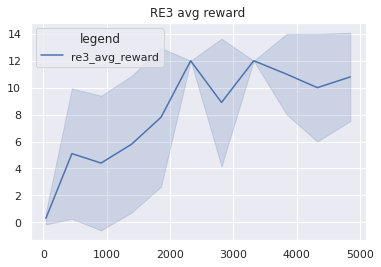

In [47]:
# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_rewards, 'b-', label='re3_avg_reward')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_rewards - re3_chkpt_std_rewards), (re3_chkpt_mean_rewards + re3_chkpt_std_rewards), color='b', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg reward") 
plt.show()



## RE3 avg steps

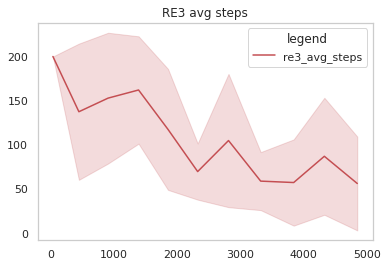

In [79]:


# https://stackoverflow.com/questions/61368805/how-to-plot-shaded-error-bands-with-seaborn

plt.plot(re3_cum_eps, re3_chkpt_mean_steps, 'r-', label='re3_avg_steps')
plt.fill_between(re3_cum_eps, (re3_chkpt_mean_steps - re3_chkpt_std_steps), (re3_chkpt_mean_steps + re3_chkpt_std_steps), 
                 color='r', alpha=0.2) 

plt.legend(title='legend')
plt.title("RE3 avg steps") 
plt.show()



# All graphs

## Average Reward

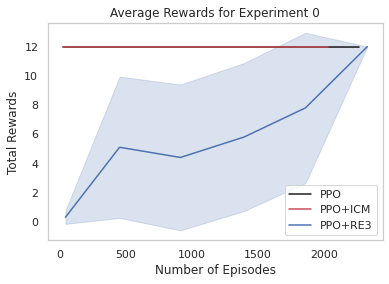

In [87]:
sns.set_style("whitegrid", {'axes.grid' : False})

#PPO 
plt.plot(ppo_cum_eps, ppo_chkpt_mean_rewards, 'k-', label='PPO')
plt.fill_between(ppo_cum_eps, ppo_chkpt_mean_rewards - ppo_chkpt_std_rewards, ppo_chkpt_mean_rewards + ppo_chkpt_std_rewards, color='k', alpha=0.2) 

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_rewards, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_rewards - icm_chkpt_std_rewards), (icm_chkpt_mean_rewards + icm_chkpt_std_rewards), color='r', alpha=0.2) 
#RE3
plt.plot(re3_cum_eps[:6], re3_chkpt_mean_rewards[:6], 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps[:6], (re3_chkpt_mean_rewards - re3_chkpt_std_rewards)[:6], (re3_chkpt_mean_rewards + re3_chkpt_std_rewards)[:6], color='b', alpha=0.2) 


plt.legend()
plt.xlabel('Number of Episodes') 
plt.ylabel('Total Rewards') 
plt.title("Average Rewards for Experiment 0") 
plt.show()


## Average Steps

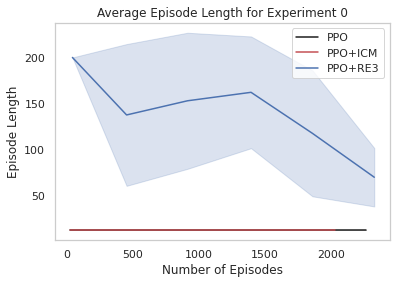

In [86]:

#PPO
plt.plot(ppo_cum_eps, ppo_chkpt_mean_steps, 'k-', label='PPO')
plt.fill_between(ppo_cum_eps, (ppo_chkpt_mean_steps - ppo_chkpt_std_steps), (ppo_chkpt_mean_steps + ppo_chkpt_std_steps), color='k', alpha=0.2) 

#ICM
plt.plot(icm_cum_eps, icm_chkpt_mean_steps, 'r-', label='PPO+ICM')
plt.fill_between(icm_cum_eps, (icm_chkpt_mean_steps - icm_chkpt_std_steps), (icm_chkpt_mean_steps + icm_chkpt_std_steps), color='r', alpha=0.2) 

#RE3
plt.plot(re3_cum_eps[:6], re3_chkpt_mean_steps[:6], 'b-', label='PPO+RE3')
plt.fill_between(re3_cum_eps[:6], (re3_chkpt_mean_steps - re3_chkpt_std_steps)[:6], (re3_chkpt_mean_steps + re3_chkpt_std_steps)[:6], color='b', alpha=0.2) 

plt.legend()
plt.xlabel('Number of Episodes') 
plt.ylabel('Episode Length') 
plt.title("Average Episode Length for Experiment 0") 
plt.show()